# Machine Learning for Traffic Accident Analysis

## Introduction
In this notebook, I will build machine learning models to predict the **severity of traffic accidents** Based on other relative factors in the data using **scikit-learn (sklearn)**.  
The steps include:
- Preparing the dataset  
- Splitting data into training and testing sets
- Building baseline models (Logistic Regression, Decision Tree)  
- Training more advanced models (Random Forest, Gradient Boosting)  
- Evaluating results with classification metrics and confusion matrices  
- Saving the best model for future use  

With this we move from **exploring and visualizing** the dataset to **predicting accident severity**.


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Loading cleaned dataset
df = pd.read_csv("../data/final_cleaned_accident_data.csv")

# Confirm load
print("Shape:", df.shape)
df.head()


Shape: (6985228, 40)


,Source,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,County,State,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,Source2,3,2016-02-08 05:46:00,39.865147,-84.058723,0.01,I-70 E,Dayton,Montgomery,OH,...,False,False,False,False,False,False,Night,Night,Night,Night
1,Source2,2,2016-02-08 06:07:59,39.928059,-82.831184,0.01,Brice Rd,Reynoldsburg,Franklin,OH,...,False,False,False,False,False,False,Night,Night,Night,Day
2,Source2,2,2016-02-08 06:49:27,39.063148,-84.032608,0.01,State Route 32,Williamsburg,Clermont,OH,...,False,False,False,False,True,False,Night,Night,Day,Day
3,Source2,3,2016-02-08 07:23:34,39.747753,-84.205582,0.01,I-75 S,Dayton,Montgomery,OH,...,False,False,False,False,False,False,Night,Day,Day,Day
4,Source2,2,2016-02-08 07:39:07,39.627781,-84.188354,0.01,Miamisburg Centerville Rd,Dayton,Montgomery,OH,...,False,False,False,False,True,False,Day,Day,Day,Day


## Data preperation

### Steps to take:
- Define the target variable (severity)
- Assign variable x for the stats to predict and y for the stats used for the prediction
- Select what features to use for prediction
- Extract time based features frpom Start_Time
- Encode catagorical variables as machine learning models only work with numbers
- scale continuous numerical features so the model doesnt become biased

In [4]:
# Use a sample of the dataset to avoid memory errors
df_sample = df.sample(500_000, random_state=42)  # 500k rows instead of 7M

y = df_sample["Severity"]
X = df_sample.drop(["Severity", "Start_Time", "Street", "City", "Zipcode"], axis=1)

# Extract time-based features
df_sample["Start_Time"] = pd.to_datetime(df_sample["Start_Time"])
X["Hour"] = df_sample["Start_Time"].dt.hour
X["DayOfWeek"] = df_sample["Start_Time"].dt.dayofweek
X["Month"] = df_sample["Start_Time"].dt.month

# Encode key categorical variables
categorical_cols = ["State", "Timezone", "Weather_Condition", 
                    "Wind_Direction", "Sunrise_Sunset"]
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale continuous features
scaler = StandardScaler()
num_cols_to_scale = [
    "Distance(mi)", "Temperature(F)", "Wind_Chill(F)",
    "Humidity(%)", "Pressure(in)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)"
]

X[num_cols_to_scale] = scaler.fit_transform(X[num_cols_to_scale])

# confirm dataset size
print("Final size of features:", X.shape)


Final size of features: (500000, 217)


## Results

The final feature set contains **500,000 rows** and **217 features**.  
This includes time-based features we created such as (`Hour`, `DayOfWeek`, `Month`), encoded categorical variables (e.g. `State`, `Weather_Condition`), and scaled numerical variables.  
This balanced dataset will be used to train and evaluate machine learning models in the next steps.


## Train/Test Split
- Split features (`X`) and target (`Y`) into random training and test sets
- Using Random splits as we are not trying to predict future accidents just how severe an accident could be based on other conditions
- typically 80/20 to ensure most of the data is trained but some left un-touched for testing

In [5]:
# 20% to test set
X_train, X_test, y_train, y_test = train_test_split(
    # using stratify so that the random split doesnt put more of one severity in the training set
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (400000, 217) (400000,)
Test set: (100000, 217) (100000,)


## Verify correct split

- Without using Stratified sampling, there can be inconsistencies in the sets (since taking a random sample and putting 80% in one and 20% in another)
- I have added a bar chat below to confirm it is balanced

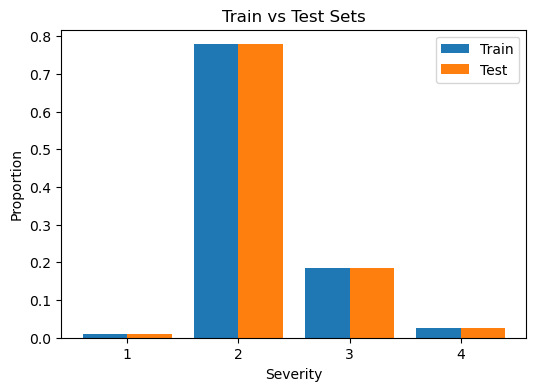

In [6]:
train_counts = y_train.value_counts(normalize=True).sort_index()
test_counts = y_test.value_counts(normalize=True).sort_index()

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(train_counts.index - 0.2, train_counts, width=0.4, label="Train")
ax.bar(test_counts.index + 0.2, test_counts, width=0.4, label="Test")

ax.set_xticks([1,2,3,4])
ax.set_xlabel("Severity")
ax.set_ylabel("Proportion")
ax.set_title("Train vs Test Sets")
ax.legend()
plt.show()

## Baseline Model: Logistic Regression  

To establish a baseline, we start with a **Logistic Regression** classifier.  
This is a simple but effective algorithm for multi-class classification, and it helps set a reference point for model performance.  

The model is trained on the **training set** (80% of the data) and then evaluated on the **test set** (20%).  

Evaluation includes:  
- **Classification report**: shows precision, recall, and F1-score for each severity level.  
- **Confusion matrix**: visualizes where the model predicts correctly and where it confuses different severity levels.  

This baseline performance will be compared against more advanced models later (e.g., Random Forest, Gradient Boosting).


In [7]:

# smaller sample + fewer features
X_train_small = X_train[["Distance(mi)", "Temperature(F)", "Humidity(%)", "Visibility(mi)"]].sample(10000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]

X_test_small = X_test[["Distance(mi)", "Temperature(F)", "Humidity(%)", "Visibility(mi)"]].sample(2000, random_state=42)
y_test_small = y_test.loc[X_test_small.index]

log_reg = LogisticRegression(max_iter=1000, solver="saga", multi_class="multinomial")
log_reg.fit(X_train_small, y_train_small)

y_pred = log_reg.predict(X_test_small)

print(classification_report(y_test_small, y_pred))


c:\Users\tuite\anaconda3\envs\accident_analysis\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.77      1.00      0.87      1547
           3       0.00      0.00      0.00       378
           4       0.00      0.00      0.00        60

    accuracy                           0.77      2000
   macro avg       0.19      0.25      0.22      2000
weighted avg       0.60      0.77      0.67      2000



c:\Users\tuite\anaconda3\envs\accident_analysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuite\anaconda3\envs\accident_analysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tuite\anaconda3\envs\accident_analysis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

## Results

We first tested **Logistic Regression** as a baseline model.  
- Accuracy was around **77%**, but this was misleading.  
- The model predicted almost all accidents as **Severity 2**, since this is the majority class.  
- As a result, it completely failed to identify **Severities 1, 3, and 4**.  

This demonstrates the challenge of **class imbalance** in the dataset and shows why a more advanced model (such as **Random Forest**) is needed to better capture patterns across all severity levels.


## Random Forest Classifier

Since Logistic Regression struggled with class imbalance, we will now train a **Random Forest Classifier**.  

Random Forests are an ensemble method that combine multiple decision trees.  
Advantages:  
- Can handle large datasets with mixed numeric/categorical features.  
- More robust to class imbalance compared to logistic regression.  
- Provide feature importance scores, giving insights into what factors matter most.  


In [8]:
# Train Random Forest (smaller sample for performance if needed)
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_small, y_train_small)

# Predictions
y_pred_rf = rf.predict(X_test_small)

# Evaluation
print(classification_report(y_test_small, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_small, y_pred_rf))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.79      0.89      0.83      1547
           3       0.30      0.19      0.23       378
           4       0.00      0.00      0.00        60

    accuracy                           0.72      2000
   macro avg       0.27      0.27      0.27      2000
weighted avg       0.66      0.72      0.69      2000


Confusion Matrix:
 [[   0   12    3    0]
 [   6 1375  163    3]
 [   1  304   72    1]
 [   0   59    1    0]]


## Results

The Random Forest model performed better than Logistic Regression:
- It correctly classified most **Severity 2 accidents** and some **Severity 3 accidents**.
- It still struggles with the rare **Severity 1 and 4 accidents**, which is expected given the dataset imbalance.
- Overall accuracy: ~72%, but macro F1-score (0.27) highlights imbalance across classes.

This shows Random Forest is more robust for this dataset, though improvements such as class weighting or resampling could help capture minority classes better.

I will add a heatmap for better visualization of miss-classifications etc.


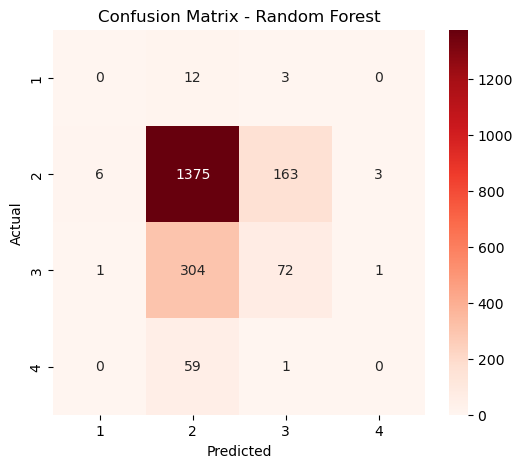

In [9]:
# Compute confusion matrix
cm = confusion_matrix(y_test_small, y_pred_rf)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


## Gradient Boosting 

After testing Logistic Regression and Random Forest, I will now train a **Gradient Boosting Classifier**.  
Gradient Boosting builds trees(estimators) sequentially, where each new tree attempts to correct the errors of the previous ones.  
This usually gives stronger predictive performance compared to standalone trees or logistic regression.  

I’ll train the model on the sampled dataset (`X_train_small`) to avoid memory issues, then evaluate it on the test set.  
The results will be compared against the previous models.


Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.78      0.99      0.87      1547
           3       0.33      0.02      0.04       378
           4       0.00      0.00      0.00        60

    accuracy                           0.77      2000
   macro avg       0.28      0.25      0.23      2000
weighted avg       0.66      0.77      0.68      2000



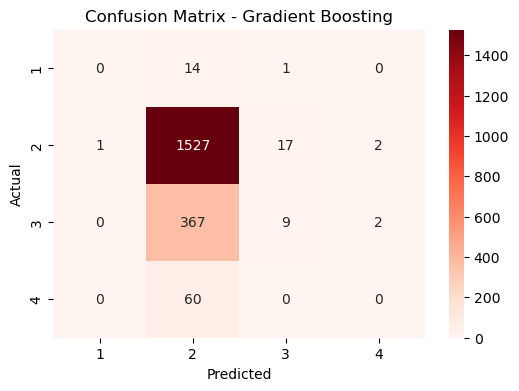

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_small, y_train_small)

# Predictions
y_pred_gb = gb_model.predict(X_test_small)

# Evaluation
print("Classification Report (Gradient Boosting):")
print(classification_report(y_test_small, y_pred_gb))

# Confusion Matrix
cm = confusion_matrix(y_test_small, y_pred_gb)

# heatmap for better visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


### Gradient Boosting Results  

The Gradient Boosting model achieved ~77% overall accuracy.  
However, once again the classification report shows it is heavily biased toward predicting **severity 2**, with very poor performance on rarer classes (1, 3, and 4).  

This confirms the dataset’s **class imbalance** problem: since most accidents are severity 2, the model learns to predict 2 almost every time.  

Next steps will involve addressing imbalance (e.g., class weights or resampling) or testing other boosting algorithms like XGBoost or LightGBM.


## Handling Class Imbalance with Class Weights  

The dataset is heavily imbalanced, with most accidents labeled as severity 2.  
As a result, previous models (Logistic Regression, Random Forest, Gradient Boosting) focused almost entirely on predicting severity 2, ignoring rarer classes (1, 3, 4).  

To address this, I will apply **class weights** to the Gradient Boosting model.  
This tells the algorithm to treat misclassifications of rare classes (like severity 3 and 4) as more important, encouraging the model to learn their patterns.  

If successful, this should improve recall and F1-scores for the minority classes, even if overall accuracy drops slightly.


Computed class weights: {1: 22.93577981651376, 2: 0.32266391326794014, 3: 1.3326226012793176, 4: 9.363295880149813}
Classification Report (Gradient Boosting with Class Weights):
              precision    recall  f1-score   support

           1       0.03      0.60      0.05        15
           2       0.84      0.28      0.42      1547
           3       0.30      0.53      0.38       378
           4       0.07      0.53      0.12        60

    accuracy                           0.34      2000
   macro avg       0.31      0.49      0.24      2000
weighted avg       0.71      0.34      0.40      2000



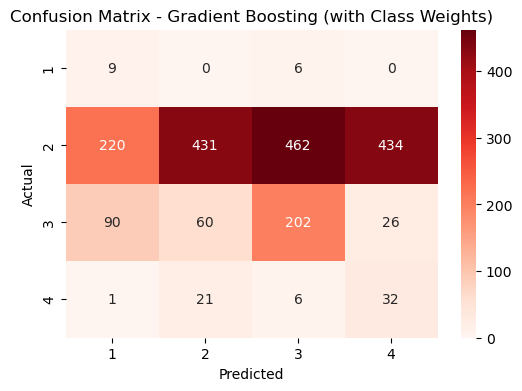

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights automatically
classes = np.unique(y_train_small)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_small)
class_weights_dict = dict(zip(classes, class_weights))

print("Computed class weights:", class_weights_dict)

# Train Gradient Boosting with sample weights
gb_model_weighted = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Apply class weights when fitting
sample_weights = y_train_small.map(class_weights_dict)
gb_model_weighted.fit(X_train_small, y_train_small, sample_weight=sample_weights)

# Predictions
y_pred_gb_weighted = gb_model_weighted.predict(X_test_small)

# Evaluation
print("Classification Report (Gradient Boosting with Class Weights):")
print(classification_report(y_test_small, y_pred_gb_weighted))

# Confusion Matrix
cm = confusion_matrix(y_test_small, y_pred_gb_weighted)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gradient Boosting (with Class Weights)")
plt.show()


## Results:  Gradient Boosting with Class Weights

Introducing **class weights** allowed the model to pay more attention to underrepresented severity levels:

- Severity **1**: recall improved from 0.00 → 0.60  
- Severity **3**: recall improved from 0.19 → 0.53  
- Severity **4**: recall improved from 0.00 → 0.53  

**Overall:**
- accuracy dropped to ~34%, compared to ~72–77% before.  
- The model no longer defaults to predicting Severity 2 but struggles with precision.  

**Takeaway:** Accuracy alone is misleading in imbalanced datasets. While the weighted model performs worse in terms of accuracy, it is more balanced in recognizing multiple severity levels, which is often more valuable in real-world use cases.
